# Preparation des données
### Initialisation du projet

In [132]:
# imports
import numpy as np
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Importation

In [133]:
import os
import pandas as pd

DATASETS_PATH = os.path.join(".\datasets")

def load_datasets_data(dataset_path=DATASETS_PATH):
	csv_general = pd.read_csv(os.path.join(dataset_path, "general_data.csv"))
	csv_manager = pd.read_csv(os.path.join(dataset_path, "manager_survey_data.csv"))
	csv_employee = pd.read_csv(os.path.join(dataset_path, "employee_survey_data.csv"))
	csv_intime = pd.read_csv(os.path.join(dataset_path, "in_time.csv"))
	csv_outtime = pd.read_csv(os.path.join(dataset_path, "out_time.csv"))
	return csv_general, csv_manager, csv_employee, csv_intime, csv_outtime

In [134]:
general_set, manager_set, employee_set, intime_set, outtime_set = load_datasets_data()

In [135]:
dataset_merge = general_set.merge(employee_set.merge(manager_set, on="EmployeeID"), on="EmployeeID")
dataset = dataset_merge.copy()
pd.DataFrame.head(dataset, 5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


### Nettoyage des données / Complétion

In [136]:
#https://prod.liveshare.vsengsaas.visualstudio.com/join?6712A4B62ABC55A3AC374AFD25A834927C4D

incomplete_attributes = ["NumCompaniesWorked","JobSatisfaction","EnvironmentSatisfaction","WorkLifeBalance", "TotalWorkingYears"]

for attribute in incomplete_attributes:
	median = dataset[attribute].median()
	dataset[attribute].fillna(median, inplace=True) # option 3

#Autre methode
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(missing_values=np.nan, strategy="median")

In [137]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

Attrition NO:  3699  Attrition YES:  711
Age


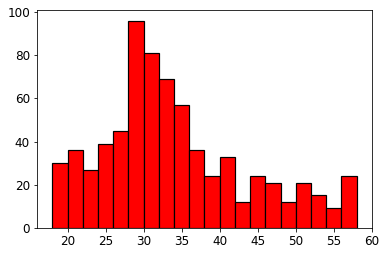

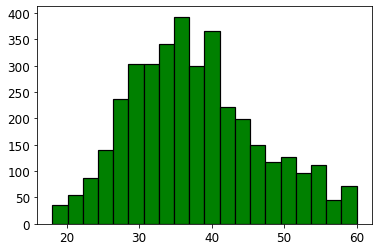

DistanceFromHome


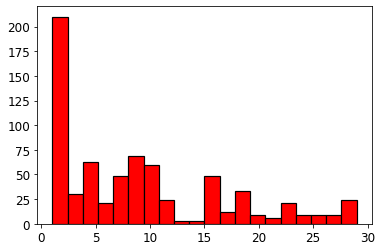

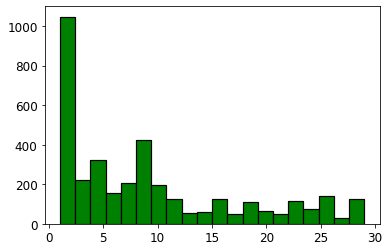

Education


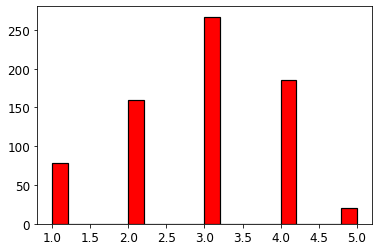

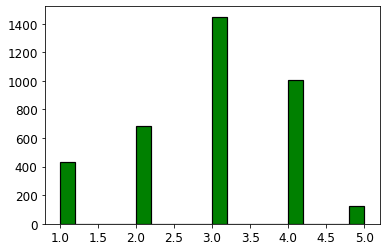

TotalWorkingYears


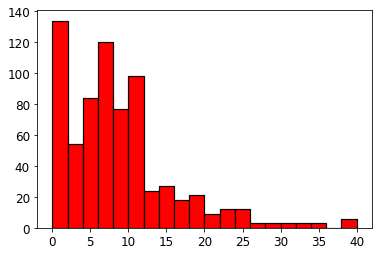

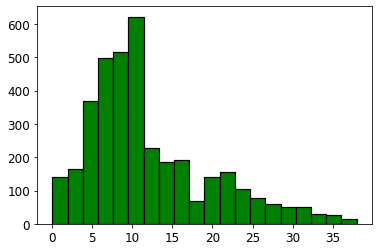

TrainingTimesLastYear


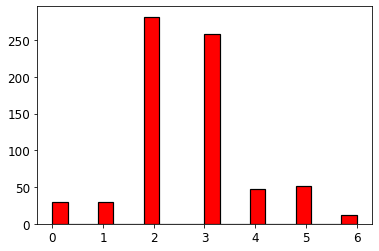

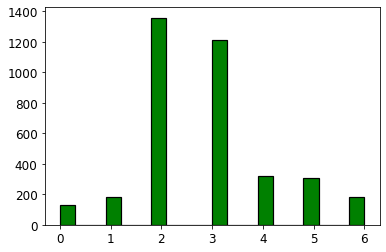

YearsAtCompany


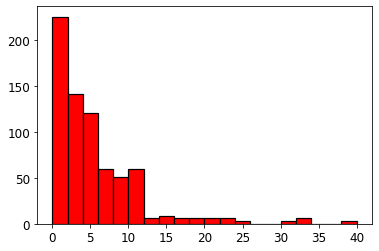

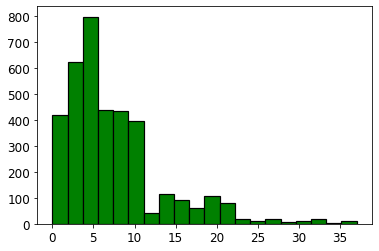

YearsSinceLastPromotion


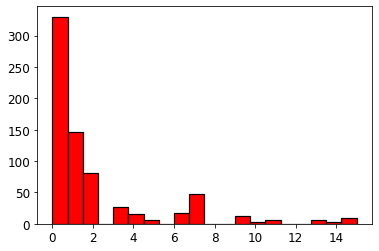

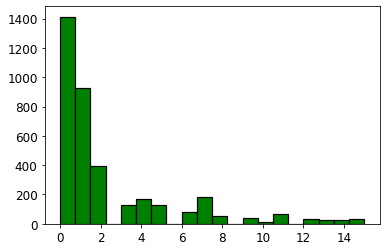

YearsWithCurrManager


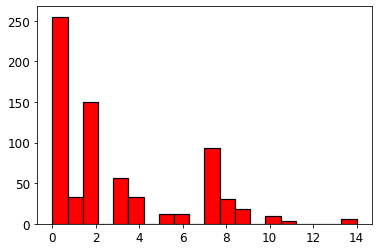

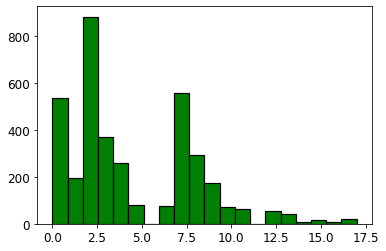

EnvironmentSatisfaction


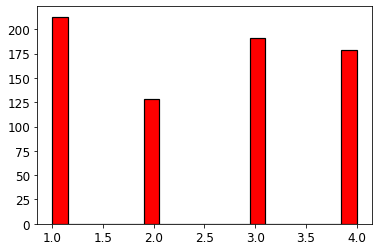

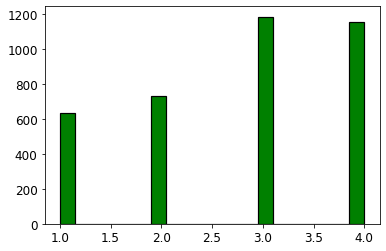

JobSatisfaction


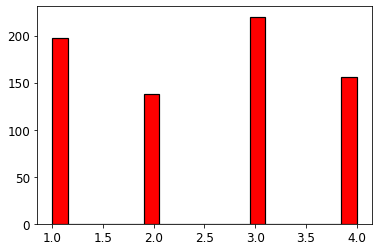

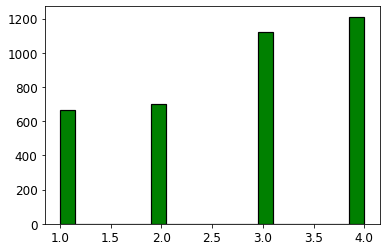

WorkLifeBalance


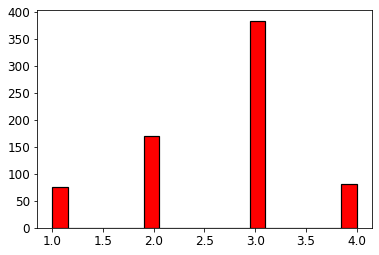

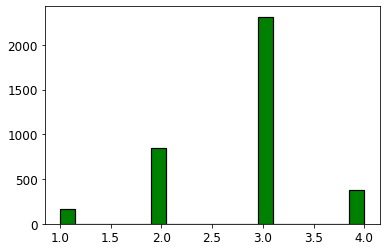

JobInvolvement


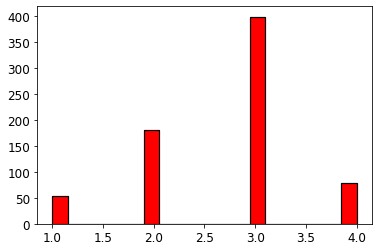

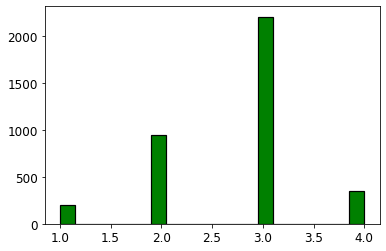

NumCompaniesWorked


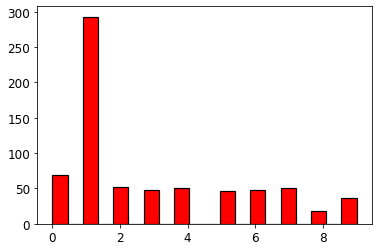

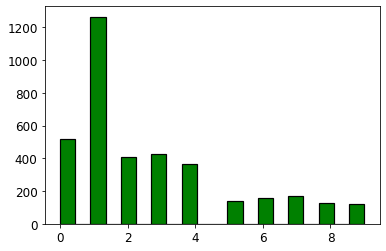

In [138]:
rawArray = ["Age","DistanceFromHome","Education","TotalWorkingYears",
	"TrainingTimesLastYear","YearsAtCompany","YearsSinceLastPromotion","YearsWithCurrManager",
	"EnvironmentSatisfaction", "JobSatisfaction", "WorkLifeBalance","JobInvolvement", "NumCompaniesWorked" ]

dataset_yes = dataset.where(dataset["Attrition"]=="Yes", 0)
dataset_no  = dataset.where(dataset["Attrition"]=="No", 1)

dataset_yes = dataset_yes.loc[dataset_yes["Attrition"] != 0]
dataset_no = dataset_no.loc[dataset_no["Attrition"] != 1]

print("Attrition NO: ", len(dataset_no) ," Attrition YES: ", len(dataset_yes))


# for col in rawArray:
#     plt.boxplot([dataset_yes[col].apply(np.int64), dataset_no[col].apply(np.int64)])
#     print(col)
#     plt.show()

for col in rawArray:
	print(col)
	plt.hist(dataset_yes[col].apply(np.int64), color="red", edgecolor='black', linewidth=1.2,bins=20)
	plt.show()
	plt.hist(dataset_no[col].apply(np.int64), color="green", edgecolor='black', linewidth=1.2,bins=20)
	plt.show()

In [139]:
corr_array = ["Age", "YearsAtCompany", "YearsSinceLastPromotion", "YearsWithCurrManager"]


In [140]:
# Data frame is created under column name Name and Attrition
data_frame = pd.DataFrame(dataset, columns=["Attrition"])
 
# Data of Attrition is converted into Binary Data
df_one = pd.get_dummies(data_frame["Attrition"])
 
# Binary Data is Concatenated into Dataframe
df_two = pd.concat((df_one, data_frame), axis=1)
 
# Attritioncolumn is dropped
df_two = df_two.drop(["Attrition"], axis=1)
 
# We want Male =0 and Female =1 So we drop Male column here
df_two = df_two.drop(["No"], axis=1)
 
# Rename the Column
result = df_two.rename(columns={"Yes": "Attrition"})

dataset_test = dataset.copy()
dataset_test["Attrition"] = result["Attrition"]

dataset_test

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,0,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,1,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,0,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,0,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,0,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,0,Travel_Rarely,Research & Development,5,4,Medical,1,4406,Female,...,10.0,5,3,0,2,4.0,1.0,3.0,3,3
4406,29,0,Travel_Rarely,Research & Development,2,4,Medical,1,4407,Male,...,10.0,2,3,0,2,4.0,4.0,3.0,2,3
4407,25,0,Travel_Rarely,Research & Development,25,2,Life Sciences,1,4408,Male,...,5.0,4,4,1,2,1.0,3.0,3.0,3,4
4408,42,0,Travel_Rarely,Sales,18,2,Medical,1,4409,Male,...,10.0,2,9,7,8,4.0,1.0,3.0,2,3


In [141]:
dataset_test.corr()["Attrition"]

Age                       -0.159205
Attrition                  1.000000
DistanceFromHome          -0.009730
Education                 -0.015111
EmployeeCount                   NaN
EmployeeID                -0.004729
JobLevel                  -0.010290
MonthlyIncome             -0.031176
NumCompaniesWorked         0.042064
PercentSalaryHike          0.032533
StandardHours                   NaN
StockOptionLevel          -0.006839
TotalWorkingYears         -0.170162
TrainingTimesLastYear     -0.049431
YearsAtCompany            -0.134392
YearsSinceLastPromotion   -0.033019
YearsWithCurrManager      -0.156199
EnvironmentSatisfaction   -0.101625
JobSatisfaction           -0.103068
WorkLifeBalance           -0.062975
JobInvolvement            -0.015588
PerformanceRating          0.023403
Name: Attrition, dtype: float64

In [142]:
dataset.describe()

,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.0,...,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000
mean,36.923810,9.192517,2.912925,1.0,2205.500000,2.063946,65029.312925,2.691837,15.209524,8.0,...,11.277324,2.799320,7.008163,2.187755,4.123129,2.725170,2.729478,2.763492,2.729932,3.153741
std,9.133301,8.105026,1.023933,0.0,1273.201673,1.106689,47068.888559,2.493912,3.659108,0.0,...,7.774490,1.288978,6.125135,3.221699,3.567327,1.089852,1.098904,0.703541,0.711400,0.360742
min,18.000000,1.000000,1.000000,1.0,1.000000,1.000000,10090.000000,0.000000,11.000000,8.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,2.000000,2.000000,1.0,1103.250000,1.000000,29110.000000,1.000000,12.000000,8.0,...,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,7.000000,3.000000,1.0,2205.500000,2.000000,49190.000000,2.000000,14.000000,8.0,...,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,14.000000,4.000000,1.0,3307.750000,3.000000,83800.000000,4.000000,18.000000,8.0,...,15.000000,3.000000,9.000000,3.000000,7.000000,4.000000,4.000000,3.000000,3.000000,3.000000
max,60.000000,29.000000,5.000000,1.0,4410.000000,5.000000,199990.000000,9.000000,25.000000,8.0,...,40.000000,6.000000,40.000000,15.000000,17.000000,4.000000,4.000000,4.000000,4.000000,4.000000


## Test Pipeline	

In [143]:
dataset_pl = dataset.copy()
ds_num = dataset_pl.select_dtypes(include=[np.number])
ds_str = dataset_pl.select_dtypes(exclude=[np.number])

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

encoder = OneHotEncoder()
encoder.fit(ds_str)
# dataset.head(10)

num_attribs = list(ds_num)
str_attribs = list(ds_str)

num_pipeline = Pipeline([
	('imputer', SimpleImputer(strategy="median")), 
	('std_scaler', StandardScaler()),			   
])

full_pipeline = ColumnTransformer([
	("num", num_pipeline, num_attribs),
	("str", encoder, str_attribs),
])

dataset_pipeline = full_pipeline.fit_transform(dataset_pl)
dataset_pipeline

array([[ 1.54136892, -0.39393818, -0.89168825, ...,  1.        ,
         0.        ,  1.        ],
       [-0.64866811,  0.09963874, -1.86842575, ...,  0.        ,
         1.        ,  1.        ],
       [-0.53916626,  0.96339837,  1.06178675, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [-1.30567922,  1.95055222, -0.89168825, ...,  1.        ,
         0.        ,  1.        ],
       [ 0.55585225,  1.0867926 , -0.89168825, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.33684855,  2.32073492,  0.08504925, ...,  0.        ,
         0.        ,  1.        ]])

In [145]:
dataset_prepared = pd.DataFrame(
    dataset_pipeline,
    columns=list(np.concatenate((num_attribs, encoder.get_feature_names(str_attribs)))))
dataset_prepared


,Age,DistanceFromHome,Education,EmployeeCount,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y
0,1.541369,-0.393938,-0.891688,0.0,-1.731658,-0.961486,1.405136,-0.678464,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,-0.648668,0.099639,-1.868426,0.0,-1.730873,-0.961486,-0.491661,-1.079486,2.129306,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,-0.539166,0.963398,1.061787,0.0,-1.730087,1.749610,2.725053,-0.678464,-0.057267,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,0.117845,-0.887515,2.038524,0.0,-1.729302,0.845911,0.386301,0.123580,-1.150554,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
4,-0.539166,0.099639,-1.868426,0.0,-1.728516,-0.961486,-0.884109,0.524602,-0.877232,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,0.555852,-0.517332,1.061787,0.0,1.728516,-0.961486,-0.100700,0.123580,0.489376,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4406,-0.867672,-0.887515,1.061787,0.0,1.729302,-0.961486,-0.812504,-0.277442,-0.057267,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4407,-1.305679,1.950552,-0.891688,0.0,1.730087,-0.057788,-0.595138,-1.079486,1.309341,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4408,0.555852,1.086793,-0.891688,0.0,1.730873,-0.961486,-0.872210,-1.079486,-0.330589,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [146]:
# temp = np.concatenate(dataset_pl.columns, encoder.get_feature_names(str_attribs), axis=None)
# len(temp)
#np.concatenate(str_attribs, dataset.columns)

In [147]:
import pandas as pd, numpy as np, seaborn as sns,matplotlib.pyplot as plt
useless_value = ['Attrition_No','StandardHours','EmployeeCount','EmployeeID','Over18_Y']
dataset_prepared = dataset_prepared.drop(useless_value, axis = 1)
dataset_prepared.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 45 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   float64
 1   DistanceFromHome                   4410 non-null   float64
 2   Education                          4410 non-null   float64
 3   JobLevel                           4410 non-null   float64
 4   MonthlyIncome                      4410 non-null   float64
 5   NumCompaniesWorked                 4410 non-null   float64
 6   PercentSalaryHike                  4410 non-null   float64
 7   StockOptionLevel                   4410 non-null   float64
 8   TotalWorkingYears                  4410 non-null   float64
 9   TrainingTimesLastYear              4410 non-null   float64
 10  YearsAtCompany                     4410 non-null   float64
 11  YearsSinceLastPromotion            4410 non-null   float

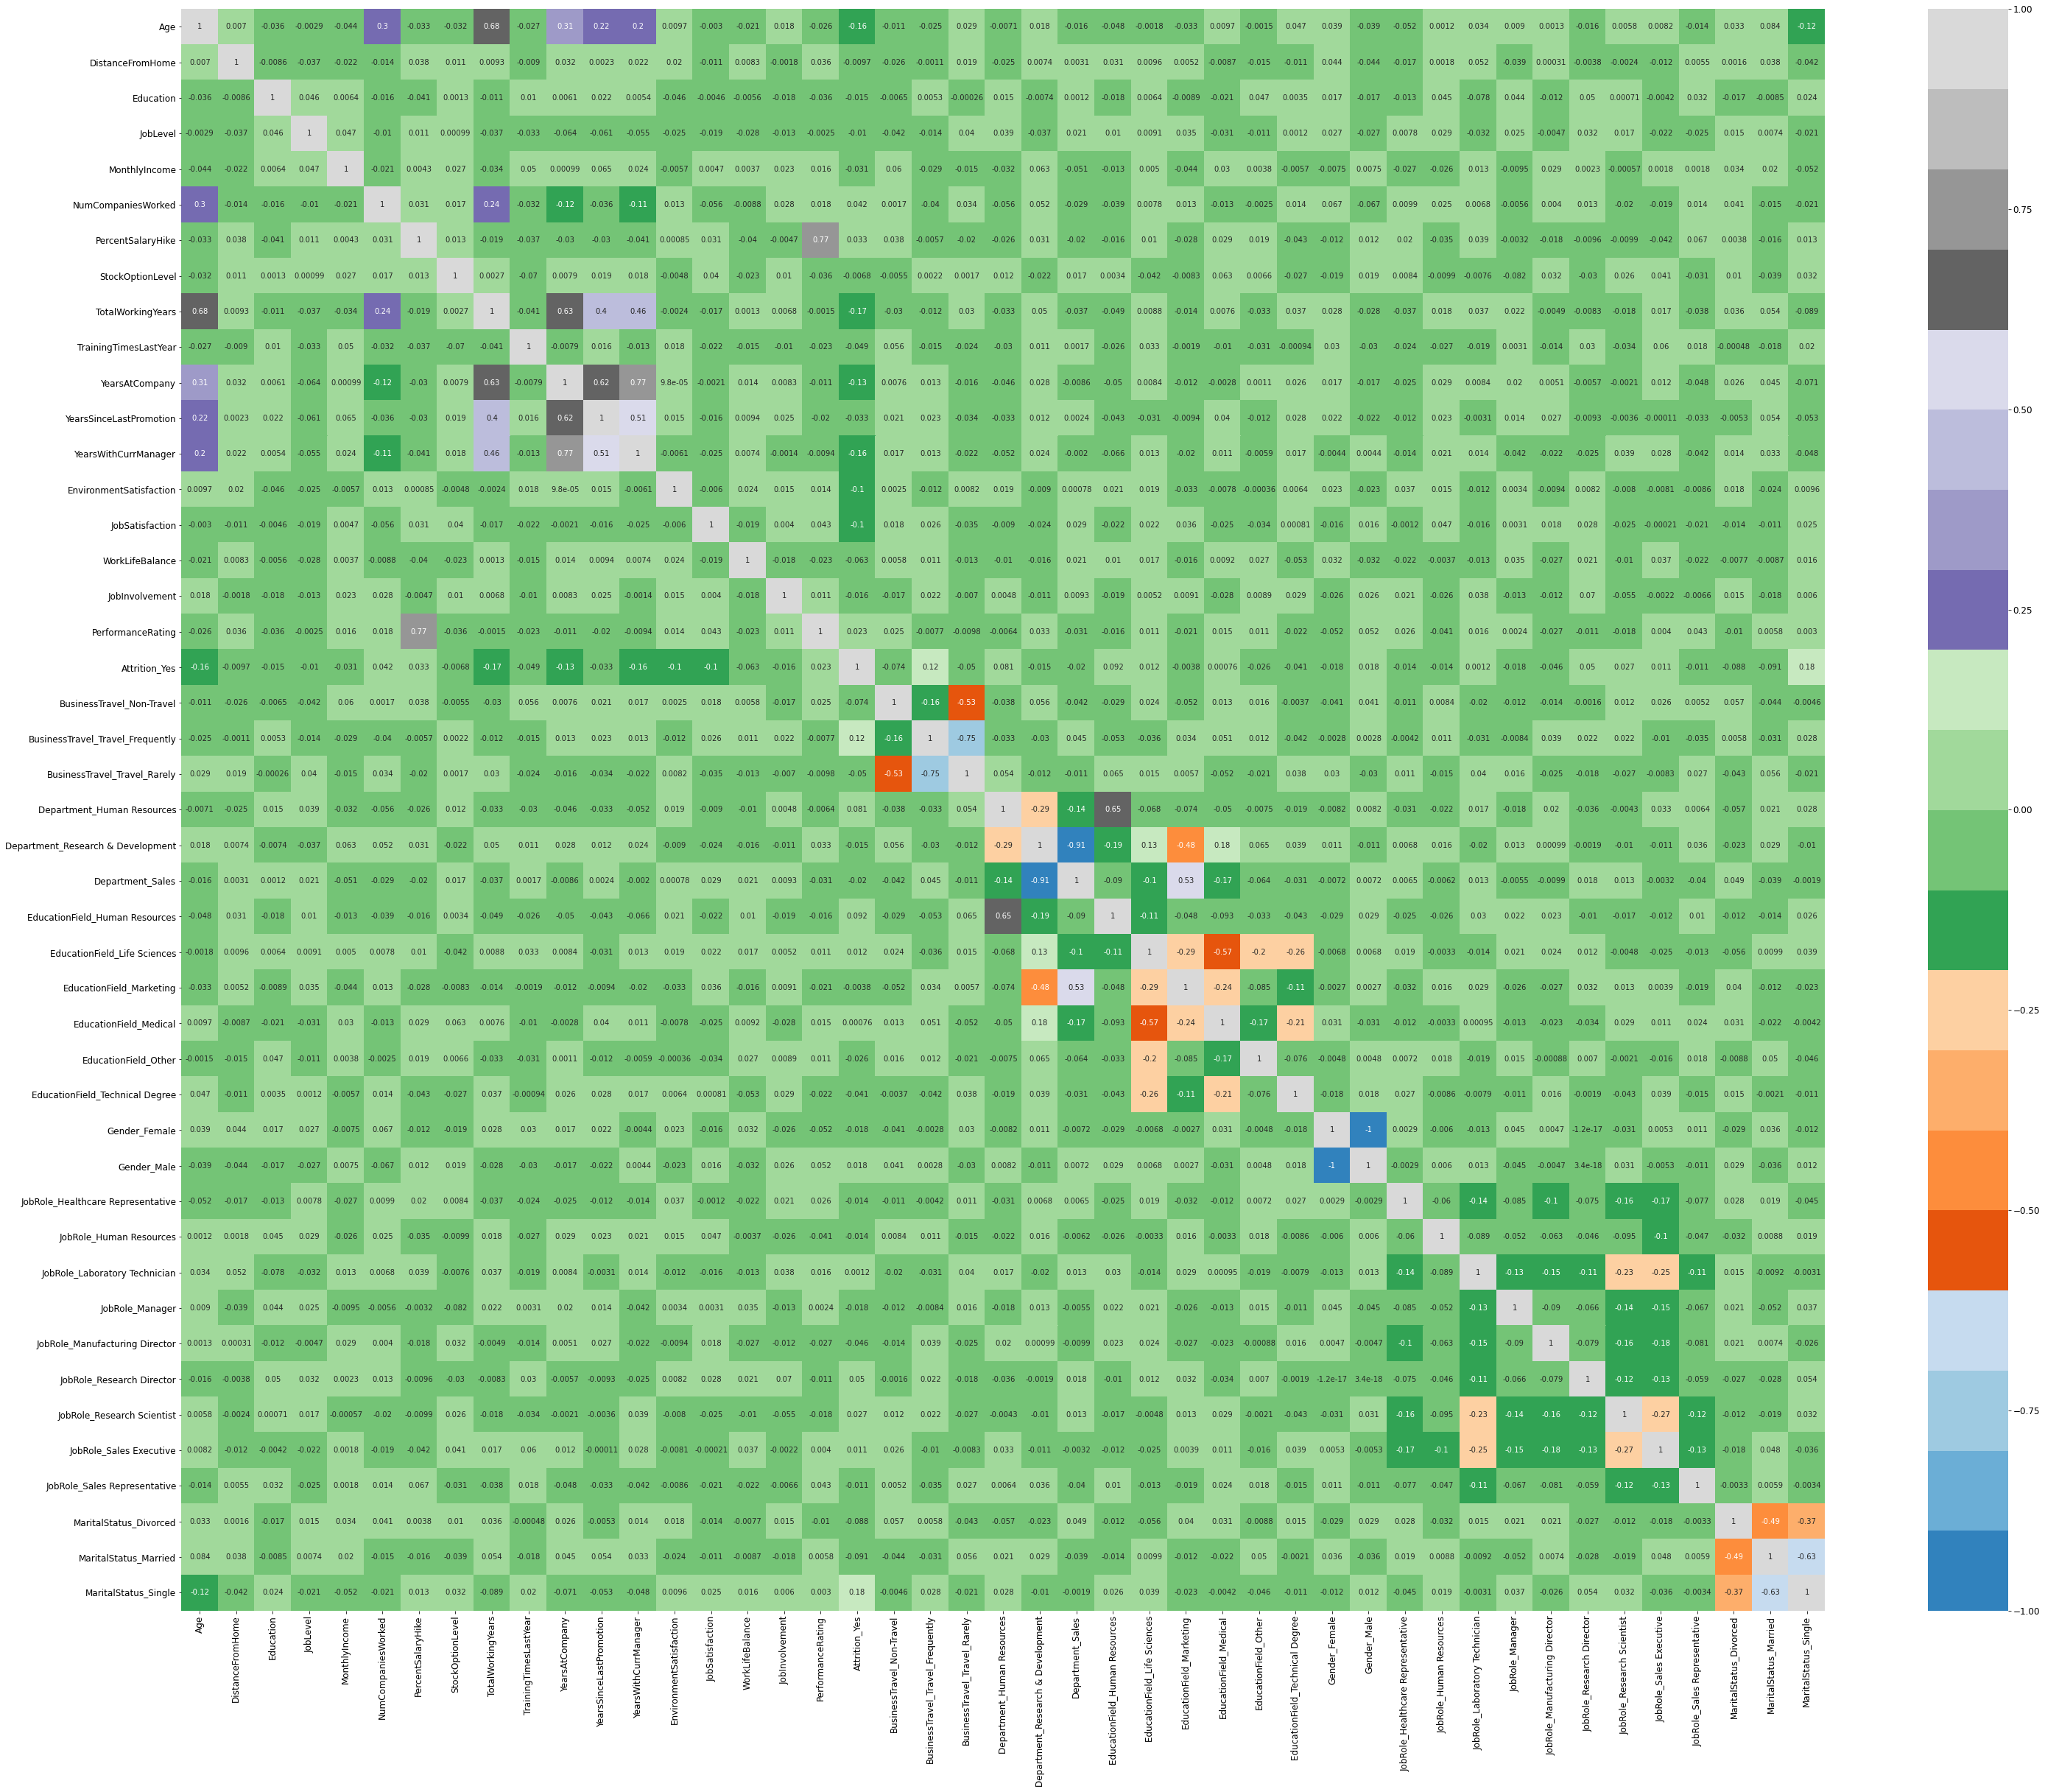

In [148]:
plt.figure(figsize = (50,40))   
sns.heatmap(dataset_prepared.corr(),annot = True,cmap="tab20c")
plt.show()

In [149]:
y = dataset_prepared['Attrition_Yes']
x = dataset_prepared.drop(['Attrition_Yes'], axis = 1)
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 44 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                4410 non-null   float64
 1   DistanceFromHome                   4410 non-null   float64
 2   Education                          4410 non-null   float64
 3   JobLevel                           4410 non-null   float64
 4   MonthlyIncome                      4410 non-null   float64
 5   NumCompaniesWorked                 4410 non-null   float64
 6   PercentSalaryHike                  4410 non-null   float64
 7   StockOptionLevel                   4410 non-null   float64
 8   TotalWorkingYears                  4410 non-null   float64
 9   TrainingTimesLastYear              4410 non-null   float64
 10  YearsAtCompany                     4410 non-null   float64
 11  YearsSinceLastPromotion            4410 non-null   float

In [150]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=100)

In [151]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.981103552532124


In [152]:
!pip install pydotplus

In [157]:
!pip install graphviz

In [155]:

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

ImportError: cannot import name 'six' from 'sklearn.externals' (C:\Users\ASUS STRIX SCAR\anaconda3\lib\site-packages\sklearn\externals\__init__.py)